### # Import packages

In [1]:
import statsmodels.api as sm
from statsmodels import tsa as TSA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### # Functions definitions

###### -> Random standard t distribution

In [2]:
def Rnd_standard_t( dof ):
    np.random.standard_t( dof )

###### ->MSE Calculation

In [3]:
def MSE(arr):
    MSE = 0
    for i in range(0, len(arr)):
        MSE += arr[i] * arr[i]
    return MSE

###### -> ARMA model generation

In [4]:
def Generate_ARMA_Series( theta, phi, n_samples, distrvs):   
    # parameters
    arparams = np.array([phi])
    maparams = np.array([theta])
    ar = np.r_[1, -arparams]
    ma = np.r_[1, maparams]
    # generate arma model
    if (distrvs != None):
        arma = sm.tsa.arma_generate_sample(ar, ma, n_samples, distrvs = Rnd_standard_t(distrvs) )   
    else:
        arma = sm.tsa.arma_generate_sample(ar, ma, n_samples)   
        
    return {
        'arma': arma,
        'ar': ar,
        'ma': ma,
        'n' : n_samples
    }

###### -> EACF calculation

In [5]:
def EACF(arma, ar_max, ma_max, show):
    def lag1(arma, lag=1):
        return pd.Series(arma).shift(lag)
    
    def reupm(m, nrow, ncol):
        k = ncol - 1
        m2 = np.empty((m.shape[0], k))
        for i in range(k):
            i1 = i + 1
            work = lag1(m1[:, i])
            work[0] = -1
            temp = m1[:, i1] - work * m1[i1, i1]/m1[i, i]
            temp[i1] = 0
            m2[:, i] = temp
        return m2
    
    def ceascf(m, cov1, nar, ncol, count, ncov, arma, armam):
        result = np.zeros(nar+1)
        result[0] = cov1[ncov + count - 1]
        for i in range(1, nar+1):
            A = np.empty((len(arma) - i, i+1))
            A[:, 0] = arma[i:]
            A[:, 1:] = armam[i:, :i]
            b = np.r_[1, -m[:i, i-1]]
            temp = A @ b
            result[i] = acf(temp, nlags=count, fft=False)[count]
        return result
    
    ar_max = ar_max + 1
    ma_max = ma_max + 1
    nar = ar_max - 1
    nma = ma_max
    ncov = nar + nma + 2
    nrow = nar + nma + 1
    ncol = nrow - 1
    arma = np.array(arma) - np.mean(arma)
    armam = np.empty((len(arma), nar))
    for i in range(nar):
        armam[:, i] = lag1(arma, lag=i+1)
    cov1 = acf(arma, nlags=ncov, fft=False)
    cov1 = np.r_[np.flip(cov1[1:]), cov1]
    ncov = ncov + 1
    m1 = np.zeros((nrow, ncol))
    for i in range(ncol):
        m1[:i+1, i] = AutoReg(arma, lags=i+1, trend='c').fit().params[1:]
        
    eacf = np.empty((ar_max, nma))
    for i in range(nma):
        m2 = reupm(m = m1, nrow = nrow, ncol = ncol)
        ncol = ncol - 1
        eacf[:, i] = ceascf(m2, cov1, nar, ncol, i+1, ncov, arma, armam)
        m1 = m2
    
    work = np.arange(1, nar+2)
    work = len(arma) - work + 1
    symbol = np.empty(eacf.shape, dtype=object)
    for i in range(nma):
        work = work - 1
        symbol[:, i] = np.where(np.abs(eacf[:, i]) > 2/np.sqrt(work), 'x', 'o')
    
    symbol = pd.DataFrame(symbol)
    if show:
        print('AR / MA')
        print(symbol)
    
    return {
        'eacf': eacf,
        'ar.max': ar_max,
        'ma.max': ma_max,
        'symbol': symbol
    }

## Q1.
## Simulate a time series 𝑦𝑡 of length 𝑛 = 100 following an ARMA(1,1) model with 𝜙 = 0.8 and 𝜃 = 0.4.

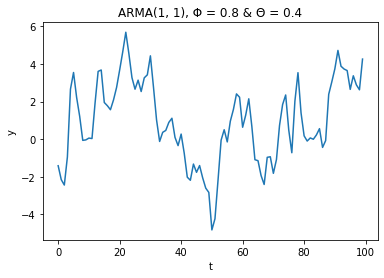

In [6]:
# generate ARMA(1,1) model 
generate_result = Generate_ARMA_Series( theta = 0.4, phi = 0.8, n_samples = 100, distrvs= None)
arma = generate_result["arma"]
plt.plot(arma)
plt.title('ARMA(1, 1), \u03A6 = 0.8 & \u0398 = 0.4')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

### (a). Calculate and plot the theoretical autocorrelation function for this model. Plot sufficient lags until the correlations are negligible.

##### ==> when lag is 25, ACF is small enough to be negligible

In [7]:
# calculate theoretical autocorrelation
lag = 25
arma_theoretical_acf = TSA.arima_process.arma_acf(generate_result["ar"], generate_result["ma"] , lags=lag)
print("Theoretical ACF of ARMA(1,1): \n", arma_theoretical_acf)

Theoretical ACF of ARMA(1,1): 
 [1.         0.88       0.704      0.5632     0.45056    0.360448
 0.2883584  0.23068672 0.18454938 0.1476395  0.1181116  0.09448928
 0.07559142 0.06047314 0.04837851 0.03870281 0.03096225 0.0247698
 0.01981584 0.01585267 0.01268214 0.01014571 0.00811657 0.00649325
 0.0051946 ]


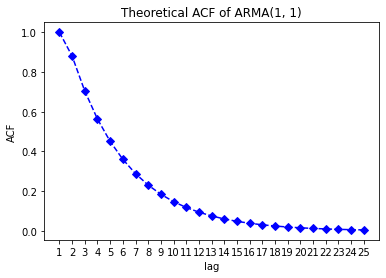

In [8]:
# plot theoretical autocorrelation
plt.plot(range(1,len(arma_theoretical_acf)+1), arma_theoretical_acf, 'bD', markersize=5, linestyle='dashed')
plt.xticks(range(1,len(arma_theoretical_acf)+1))
plt.title('Theoretical ACF of ARMA(1, 1)')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show()

### (b). Calculate and plot the sample ACF for your simulated series. How well do the values and patterns match the theoretical ACF from part (a)?

##### ==> Accroding to two ACF charts, we observe that the absolute value of sample ACF and theoretical ACF is similar, and  both of their values seems to approache to zero as the lag increased.

In [9]:
# calculate sample autocorrelation
Sample_ACF = TSA.stattools.acf(arma)
print("Sample ACF of ARMA(1,1): \n", Sample_ACF)

Sample ACF of ARMA(1,1): 
 [ 1.          0.85211822  0.64264503  0.5022955   0.41451193  0.37118859
  0.32910937  0.27811684  0.24172305  0.18375757  0.09239779 -0.01052974
 -0.06607858 -0.05521301  0.00633437  0.07890531  0.11861468  0.07746158
 -0.00607977 -0.09510608 -0.17733343 -0.22250555 -0.25326697 -0.26754548
 -0.25318409 -0.24845391 -0.28589423 -0.33610024 -0.35192236 -0.31405634
 -0.22676475 -0.12074972 -0.05597714 -0.03145559 -0.03196764 -0.04443062
 -0.05813404 -0.0779258  -0.10924483 -0.12296697 -0.12373468]


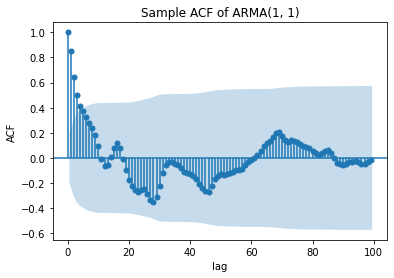

In [10]:
# plot sample autocorrelation
Sample_ACF_plot = sm.graphics.tsa.plot_acf(arma, lags=generate_result["n"]-1)
plt.title('Sample ACF of ARMA(1, 1)')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show(Sample_ACF_plot)

### (c). Calculate and interpret the sample EACF for this series. Does the EACF help you specify the correct orders for the model?

##### ==> Definitely yes, we can check EACF matrix to judge whether the orders is correct or not, and it shows it ARMA(1, 1) is a proper model for the series

In [11]:
lag = 6
EACF_result = EACF(arma, lag, lag, True)
print('\n EACF Matrix: \n', np.around(EACF_result['eacf'], decimals=3))

AR / MA
   0  1  2  3  4  5  6
0  x  x  x  x  x  x  x
1  x  o  o  o  o  o  o
2  x  x  o  o  o  o  o
3  x  x  o  o  o  o  o
4  x  x  o  o  o  o  o
5  x  o  o  o  o  o  o
6  x  o  x  o  o  o  o

 EACF Matrix: 
 [[ 0.852  0.643  0.502  0.415  0.371  0.329  0.278]
 [ 0.38  -0.143 -0.129 -0.062  0.001  0.029 -0.069]
 [ 0.503 -0.409 -0.06  -0.048 -0.003 -0.001 -0.022]
 [ 0.263 -0.337  0.145  0.038 -0.015 -0.001 -0.002]
 [ 0.463 -0.313  0.133  0.053 -0.008  0.    -0.002]
 [ 0.277  0.009 -0.089 -0.047  0.001  0.002 -0.018]
 [ 0.258  0.011 -0.267 -0.032  0.001  0.014 -0.061]]


### (d). Repeat parts (b) and (c) with a new simulation using the same parameter values but sample size 𝑛 = 48.

Sample ACF of ARMA(1,1): 
 [ 1.          0.64175372  0.11246679 -0.05037335  0.07634224  0.25940664
  0.26832591  0.09958358 -0.0355569  -0.05059778 -0.07320971 -0.11947987
 -0.1186753  -0.08027583  0.0016266   0.07592977  0.02398098 -0.17250353
 -0.29158915 -0.22048773 -0.06682165  0.03829624 -0.02464825 -0.16424319
 -0.20394233 -0.14611582 -0.12488319 -0.17000541 -0.18599753 -0.15118908
 -0.09753755 -0.08282478 -0.13603208 -0.17505236 -0.12853057 -0.02121154
  0.07130586  0.11218457  0.08846514  0.07480029  0.11197697]


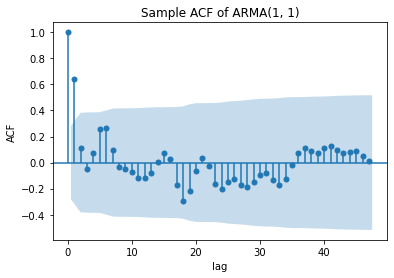

AR / MA
   0  1  2  3  4  5
0  x  o  o  o  o  o
1  x  o  o  o  o  o
2  x  o  o  o  o  o
3  o  x  x  o  o  o
4  o  x  x  o  o  o
5  x  o  o  o  o  o

 EACF Matrix: 
 [[ 0.642  0.112 -0.05   0.076  0.259  0.268]
 [ 0.575  0.176 -0.031  0.024  0.187  0.293]
 [ 0.528  0.102 -0.148 -0.045  0.084  0.245]
 [ 0.073 -0.393  0.466 -0.165 -0.145  0.246]
 [ 0.077 -0.484  0.457 -0.207 -0.188  0.272]
 [ 0.426  0.115 -0.064  0.03   0.091  0.123]]


In [12]:
# generate ARMA model
generate_result = Generate_ARMA_Series( 0.8, 0.4, 48, None)
arma = generate_result["arma"]

# (b) part 
Sample_ACF = TSA.stattools.acf(arma)
print("Sample ACF of ARMA(1,1): \n", Sample_ACF)

Sample_ACF_plot = sm.graphics.tsa.plot_acf(arma, lags = generate_result["n"]-1)
plt.title('Sample ACF of ARMA(1, 1)')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show(Sample_ACF_plot)

# (c) part
lag = 5
EACF_result = EACF(arma, lag, lag, True)
print('\n EACF Matrix: \n', np.around(EACF_result['eacf'], decimals=3))

### (e). Repeat parts (b) and (c) with a new simulation using the same parameter values but sample size 𝑛 = 200.

Sample ACF of ARMA(1,1): 

[ 1.          0.70091226  0.27376214  0.06299574 -0.0249657  -0.02781755
  0.00976616  0.02600941 -0.01733512 -0.09243786 -0.16565636 -0.18532411
 -0.14880865 -0.1001873  -0.09014309 -0.13484017 -0.17168768 -0.13314609
 -0.05007045  0.02873304  0.09927526  0.14543997  0.12789457  0.10460865
  0.12801225  0.16581361  0.15779467  0.12165942  0.08475688  0.01163715
 -0.06768417 -0.10350753 -0.09065144 -0.05974063 -0.02834392  0.00864675
  0.02983824  0.00416671 -0.06271818 -0.13707576 -0.14670204]


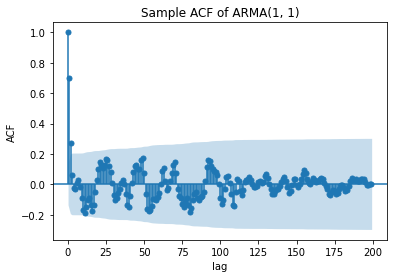

AR / MA
   0  1  2  3  4  5  6  7  8  9  10
0   x  x  o  o  o  o  o  o  o  x  x
1   x  x  o  o  o  o  o  o  o  o  o
2   x  x  o  o  o  o  o  o  o  o  o
3   x  o  x  o  o  o  o  o  o  o  o
4   x  x  x  o  o  o  o  o  o  o  o
5   x  x  x  o  o  o  o  o  o  o  o
6   x  o  x  o  o  x  x  o  o  o  o
7   x  x  x  x  x  x  o  o  o  o  o
8   o  x  x  x  o  x  o  o  o  o  o
9   o  x  x  o  o  x  o  o  x  o  o
10  x  x  x  x  o  o  o  o  x  o  o

 EACF Matrix: 
 [[ 0.701  0.274  0.063 -0.025 -0.028  0.01   0.026 -0.017 -0.092 -0.166
  -0.185]
 [ 0.514  0.164  0.101 -0.068 -0.038  0.024  0.021 -0.013 -0.046 -0.083
  -0.093]
 [ 0.42  -0.29   0.118  0.013  0.021 -0.027 -0.031 -0.028 -0.038 -0.025
  -0.063]
 [ 0.486  0.133  0.443 -0.001  0.032 -0.016 -0.031 -0.021 -0.031 -0.013
  -0.   ]
 [ 0.499 -0.332  0.439 -0.02   0.031 -0.032 -0.021 -0.026 -0.038 -0.
  -0.004]
 [ 0.34  -0.239  0.365  0.089 -0.142 -0.044  0.077 -0.054 -0.062 -0.033
   0.01 ]
 [ 0.487  0.056  0.39   0.074 -0.144 -0.153  0.184 -0.

In [13]:
# generate ARMA model
generate_result = Generate_ARMA_Series( 0.8, 0.4, 200, None)
arma = generate_result["arma"]

# (b) part 
Sample_ACF = TSA.stattools.acf(arma)
print("Sample ACF of ARMA(1,1): \n")
print(Sample_ACF)

Sample_ACF_plot = sm.graphics.tsa.plot_acf(arma, lags=generate_result["n"]-1)
plt.title('Sample ACF of ARMA(1, 1)')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show(Sample_ACF_plot)

# (c) part
lag = 10
EACF_result = EACF(arma, lag, lag, True)
print('\n EACF Matrix: \n', np.around(EACF_result['eacf'], decimals=3))

## Q2.
## Simulate an ARMA(1,1) series with 𝜙 = 0.7, 𝜃 = −0.6, 𝑛 = 48 but with error terms from a t-distribution with degrees of freedom 6.

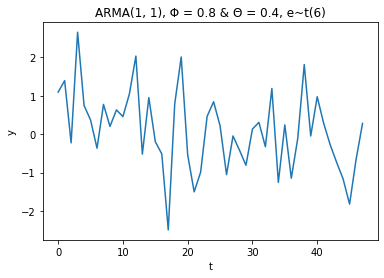

In [14]:
# generate ARMA model with e~t(6)
generate_result = Generate_ARMA_Series( theta = -0.6, phi = 0.7, n_samples = 48, distrvs = 6.0)
arma = generate_result["arma"]
plt.plot(arma)
plt.title('ARMA(1, 1), \u03A6 = 0.8 & \u0398 = 0.4, e~t(6)')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

### (a). show the sample EACF of the series. Is an ARMA(1,1) model suggested?

##### ==> Not suggested, by the result of the EACF matrix, we can conclude that ARMA(1, 1) is not a proper model

In [15]:
lag = 10
EACF_result = EACF(arma, lag, lag, True)
print('\n EACF Matrix: \n', np.around(EACF_result['eacf'], decimals=3))

AR / MA
   0  1  2  3  4  5  6  7  8  9  10
0   o  o  o  o  o  o  o  o  o  o  o
1   o  o  o  o  o  o  o  o  o  o  o
2   o  o  o  o  o  o  o  o  o  o  o
3   x  x  o  o  o  o  o  o  o  o  o
4   x  x  o  o  o  o  o  o  o  o  o
5   x  o  o  o  o  o  o  o  o  o  o
6   x  o  o  o  o  o  o  o  o  o  o
7   x  o  o  x  o  o  o  o  o  o  o
8   x  o  o  o  x  o  o  o  o  o  o
9   o  o  o  o  o  o  o  o  o  o  o
10  o  x  x  o  o  o  o  o  o  o  o

 EACF Matrix: 
 [[ 0.151  0.013 -0.049  0.051  0.057 -0.062  0.06   0.118  0.152 -0.062
   0.123]
 [ 0.039  0.037 -0.027  0.078  0.038 -0.008  0.034  0.026  0.145 -0.031
   0.085]
 [-0.099  0.207  0.001 -0.03   0.068 -0.025  0.059  0.004  0.068 -0.145
   0.004]
 [ 0.473  0.312  0.135 -0.031  0.054  0.013  0.045  0.021  0.075 -0.034
   0.074]
 [-0.447  0.386 -0.002  0.045  0.061  0.059  0.137  0.036  0.051 -0.114
  -0.014]
 [ 0.479 -0.002 -0.308  0.025  0.24  -0.026  0.035 -0.027  0.034  0.012
  -0.068]
 [ 0.452 -0.02  -0.231  0.07   0.259 -0.08  -0.045 

### (b). Estimate 𝜙 and 𝜃 from the series and comment on the results.

##### ==> As we set 𝜙 = 0.7, 𝜃 = −0.6 with e~t(6) to form the ARMA(1, 1) , the formulated model wrongly estimate 𝜙 & 𝜃 with a large error

In [16]:
model_ARMA11_fit = sm.tsa.ARMA(arma , (1, 1)).fit(trend='nc', disp=0)
print(model_ARMA11_fit.params)

[ 0.99267269 -0.99999995]


## Q3.
## The data file named robot contains a time series obtained from an industrial robot. The robot was put through a sequence of maneuvers, and the distance from a desired ending point was recorded in inches.

In [17]:
# read the csv
df_robot = pd.read_csv("C:\\Users\\TerryYang\\Desktop\\Github\\2021-TSA-Assignment-NTUIIE\\Homework #6\\TSA HW06.robot.csv")
print(df_robot)

      robot
0    0.0011
1    0.0011
2    0.0024
3    0.0000
4   -0.0018
..      ...
319  0.0008
320  0.0044
321  0.0044
322  0.0002
323  0.0036

[324 rows x 1 columns]


### (a). Display the time series plot of the data. Based on this information, do these data appear to come from a stationary or nonstationary process?

##### ==> Within this scope to examine the time series, we can not observe much variance between points and means. Thus, it might be a stationary time series, yet we can never sure unless we observe the whole time series.

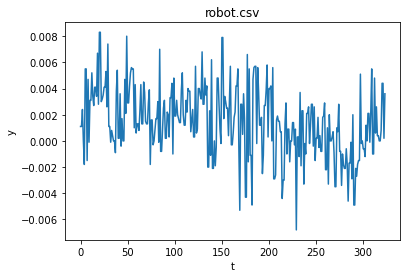

In [18]:
# plot robot.csv
plt.title('robot.csv')
plt.xlabel('t')
plt.ylabel('y')
plt.plot(df_robot)
plt.show()

### (b). Calculate and plot the sample ACF and PACF for these data. Based on this additional information, do these data appear to come from a stationary or nonstationary process?

##### ==> we can clearly see that some ACF points are outside the control limit, which meand the ACF is to large if this time series. Thus, we have to conclude that it's a nonstationary time series.

ACF of the data:
 [1.         0.30783324 0.25566978 0.23055698 0.17865198 0.22107288
 0.27033903 0.24611092 0.21142418 0.17727591 0.0657404  0.14272676
 0.22197397 0.18413854 0.14504361 0.17153502 0.07790696 0.11469899
 0.10633323 0.07433559 0.14076585 0.12032392 0.04183479 0.1224336
 0.14076818 0.09712557 0.10132883 0.08767593 0.03942908 0.07944897
 0.04192904 0.12437817 0.15369894 0.18374963 0.19621703 0.09851629
 0.05004306 0.11206087 0.18417144 0.1033046  0.1237883 ] 



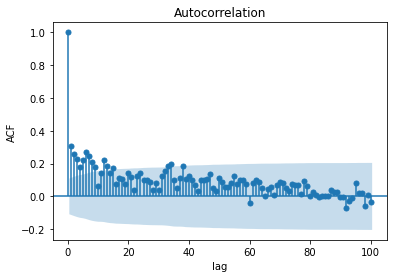

In [19]:
# calculate & plot ACF
data_acf = TSA.stattools.acf(df_robot)
print("ACF of the data:\n", data_acf, "\n")
plot = sm.graphics.tsa.plot_acf(df_robot, lags=100)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show(plot)

PACF of the data:
 [ 1.          0.30878629  0.17897378  0.12816037  0.05801476  0.12187917
  0.16098183  0.0985724   0.04634826  0.01701061 -0.10217277  0.04309717
  0.12675472  0.03966536 -0.02222452  0.05428249 -0.04340087  0.02460064
 -0.01322475 -0.04871273  0.04106402  0.0253549  -0.04662129  0.07685925
  0.06815938  0.00706725 -0.01205642 -0.0087051  -0.04932047  0.0086784
 -0.04167843  0.10873151  0.07275315  0.13505584  0.15500038 -0.05500797
 -0.11228575  0.0297702   0.08784812 -0.06573    -0.02510901] 



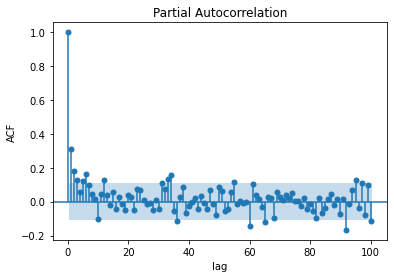

In [20]:
# calculate & plot PACF
data_acf = TSA.stattools.pacf(df_robot)
print("PACF of the data:\n", data_acf, "\n")
plot = sm.graphics.tsa.plot_pacf(df_robot, lags=100)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show(plot)

## (c). Calculate and interpret the sample EACF.

In [21]:
result_EACF =  EACF(df_robot.iloc[:, 0], 5, 5, True)
print('\n ECAF Matrix: \n', np.around(result_EACF['eacf'], decimals=3))

AR / MA
   0  1  2  3  4  5
0  x  x  x  x  x  x
1  x  o  o  o  o  o
2  x  x  o  o  o  o
3  x  x  o  o  o  o
4  x  x  x  x  o  o
5  x  x  x  o  o  o

 ECAF Matrix: 
 [[ 0.308  0.256  0.231  0.179  0.221  0.27 ]
 [-0.442 -0.02   0.029 -0.058  0.003  0.055]
 [-0.478 -0.368 -0.009 -0.06   0.004  0.047]
 [-0.378 -0.2    0.055 -0.058  0.008  0.047]
 [-0.391 -0.203 -0.366 -0.113  0.012  0.004]
 [-0.481  0.186 -0.225  0.102  0.009  0.001]]


## (d). Estimate the parameters of an AR(1) model and IMA(1, 1) for these data, respectively.

In [22]:
# AR(1)
model_AR1 = AutoReg(df_robot, lags=1)
model_AR1_fit = model_AR1.fit()
print("AR(1) Model:\n", model_AR1_fit.params)
print(model_AR1_fit.summary())

AR(1) Model:
 intercept    0.001007
robot.L1     0.308450
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:                  robot   No. Observations:                  324
Model:                     AutoReg(1)   Log Likelihood                1470.544
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 05 Dec 2021   AIC                            -11.925
Time:                        02:16:41   BIC                            -11.890
Sample:                             1   HQIC                           -11.911
                                  324                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      6.246      0.000       0.001       0.001
robot.L1       0.3084      0.053      5.821      0.000    

In [23]:
#IMA(1, 1)
model_IMA = ARIMA(df_robot, order=(0,1,1))
model_IMA_fit = model_IMA.fit()
print("\n\nIMA(1,1) Model:\n", model_IMA_fit.params)
print(model_IMA_fit.summary())



IMA(1,1) Model:
 ma.L1    -0.652171
sigma2    0.000006
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  robot   No. Observations:                  324
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1471.292
Date:                Sun, 05 Dec 2021   AIC                          -2938.583
Time:                        02:16:43   BIC                          -2931.028
Sample:                             0   HQIC                         -2935.567
                                - 324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6522      0.044    -14.731      0.000      -0.739      -0.565
sigma2       6.44e-06   4.94e-07     13.045      0.000    5

## (e). Compare the results from parts (d) in terms of AIC and discuss the residual tests.

##### ==> by the AIC value, we conclude that IMA(1, 1) can fit the series better than AR(1) does, Yet AR(1) has smaller MSE than IMA(1, 1)

In [25]:
# calculate AIC
print("AIC of AR(1) model: \n", model_AR1_fit.aic)
print("AIC of IMA(1, 1) model: \n", model_IMA_fit.aic)

AIC of AR(1) model: 
 -11.924836254711051
AIC of IMA(1, 1) model: 
 -2938.5832319396595


In [26]:
# residual tests
predict_AR = model_AR1.predict(start=0, end=(len(df_robot)), params = model_AR1_fit.params).tolist()
predict_IMA = model_IMA_fit.predict( params = model_IMA_fit.params).tolist()
for i in range(len(df_robot)):
    df_robot.loc[i, 'residual_AR'] = predict_AR[i] - df_robot['robot'][i]
    df_robot.loc[i, 'residual_IMA'] = predict_IMA[i] - df_robot['robot'][i]

MSE of AR(1) model:  0.0011098060582185529


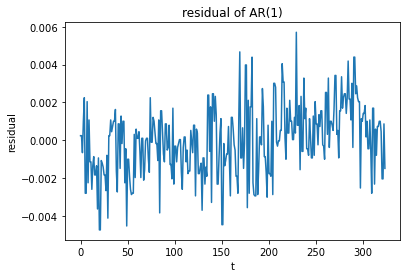

In [27]:
print("MSE of AR(1) model: ", MSE(df_robot.loc[:, 'residual_AR']))
plt.plot(df_robot.loc[:, 'residual_AR'])
plt.title('residual of AR(1)')
plt.xlabel('t')
plt.ylabel('residual')
plt.show()

MSE of AR(1) IMA(1,1):  0.0020888308987375027


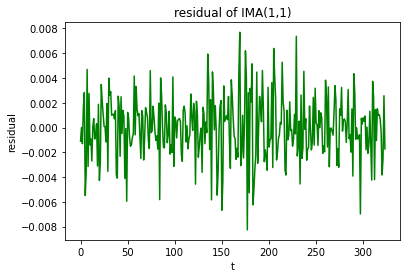

In [28]:
print("MSE of AR(1) IMA(1,1): ", MSE(df_robot.loc[:, 'residual_IMA']))
plt.plot(df_robot.loc[:, 'residual_IMA'], "g")
plt.xlabel('t')
plt.title('residual of IMA(1,1)')
plt.ylabel('residual')
plt.show()